  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00, 11.10it/s]


Overall Accuracy (Top-1): 0.905
Top-2 Accuracy: 0.968
Classification Report:
              precision    recall  f1-score   support

       chair       0.94      0.96      0.95       100
        sofa       0.91      0.97      0.94       100
      toilet       0.96      0.97      0.97       100
 night_stand       0.88      0.74      0.81        86
     bathtub       0.98      0.82      0.89        50
     dresser       0.81      0.91      0.86        86
         bed       0.93      1.00      0.96       100
        desk       0.82      0.81      0.82        86
     monitor       1.00      0.94      0.97       100
       table       0.85      0.85      0.85       100

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.90       908
weighted avg       0.91      0.91      0.90       908



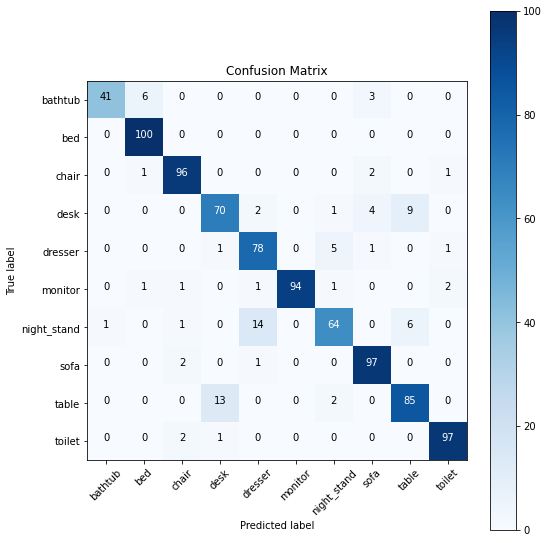

In [10]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from modelnetvoxel_dataset import ModelNetDatasetVoxel
from cnn_model import *
from resnet_models import *

num_classes = 10
grid_size = 32
object_size = 28
pitch_rescale = 1
no_of_rotations = 4
DATA_DIR = f"ModelNet10Voxel_{grid_size}_{object_size}_{pitch_rescale}_{no_of_rotations}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

dataset = ModelNetDatasetVoxel(DATA_DIR, train=True)
train_datapoints = int(0.8 * len(dataset))
validation_datapoints = len(dataset) - train_datapoints
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_datapoints, validation_datapoints])
test_dataset = ModelNetDatasetVoxel(DATA_DIR, train=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=int(os.cpu_count()))

# Load the model
model = Simple3DCNN(num_classes).to(device)
model.load_state_dict(torch.load("best_Simple3DCNN_val_loss_0.088_val_acc_0.97.pt"))
# Set model to evaluation mode
model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_targets = []
top2_correct = 0  # Counter for top-2 accuracy

iterator = tqdm(test_dataloader)
for inputs, targets in iterator:
    # Move data to device
    inputs = inputs.unsqueeze(1).to(device)
    targets = targets.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Convert outputs to predicted labels
    _, top2_predicted = torch.topk(outputs, 2, dim=1)

    # Count correct predictions in top-2
    for i in range(targets.size(0)):
        if targets[i].item() in top2_predicted[i].cpu().numpy():
            top2_correct += 1

    # Convert outputs to predicted labels (top-1 for overall accuracy)
    _, predicted = torch.max(outputs, 1)

    # Append to lists
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# Calculate overall accuracy (Top-1 Accuracy)
overall_accuracy = accuracy_score(all_targets, all_predictions)
print(f"Overall Accuracy (Top-1): {overall_accuracy:.3f}")

# Calculate Top-2 accuracy
top2_accuracy = top2_correct / len(all_targets)
print(f"Top-2 Accuracy: {top2_accuracy:.3f}")

# Calculate accuracy per class
class_names = [test_dataset.class_map.get(key) for key in range(num_classes)]
class_report = classification_report(
    all_targets, all_predictions, target_names=class_names
)
print("Classification Report:")
print(class_report)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

sorted_indices = np.argsort(class_names)
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_cm = cm[sorted_indices][:, sorted_indices]

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(sorted_cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(sorted_class_names))
plt.xticks(tick_marks, sorted_class_names, rotation=45)
plt.yticks(tick_marks, sorted_class_names)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()

# Print numerical values in each cell of the matrix
fmt = "d"
thresh = sorted_cm.max() / 2.0
for i, j in itertools.product(range(sorted_cm.shape[0]), range(sorted_cm.shape[1])):
    plt.text(
        j,
        i,
        format(sorted_cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if sorted_cm[i, j] > thresh else "black",
    )

plt.show()

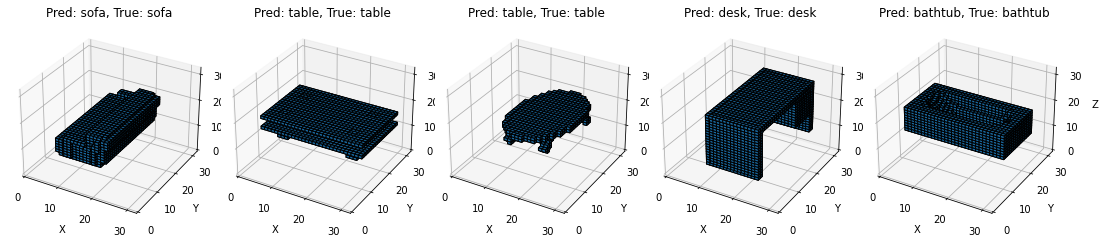

In [3]:
# Choose random samples
num_samples = 5  # Number of random samples to predict
random_indices = random.sample(range(len(dataset)), num_samples)

fig = plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    # Get a random sample from the test set
    sample, target = dataset[idx]
    sample = sample.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict with the model
    with torch.no_grad():
        output = model(sample.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    # Convert predicted and target labels to numpy if needed
    predicted_label = predicted.item()
    true_label = target.item()

    # Plot the voxel grid
    sample_np = sample.cpu().squeeze().numpy()  
    ax = fig.add_subplot(1, num_samples, i + 1, projection="3d")

    # Voxel plot
    sample_np = (sample_np + 1) / 2
    ax.voxels(sample_np, edgecolor="k")

    ax.set_title(
        f"Pred: {test_dataset.class_map.get(predicted_label)}, True: {test_dataset.class_map.get(true_label)}"
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, sample_np.shape[0])
    ax.set_ylim(0, sample_np.shape[1])
    ax.set_zlim(0, sample_np.shape[2])

plt.tight_layout()
plt.show()

Some examples of the test dataset being guessed

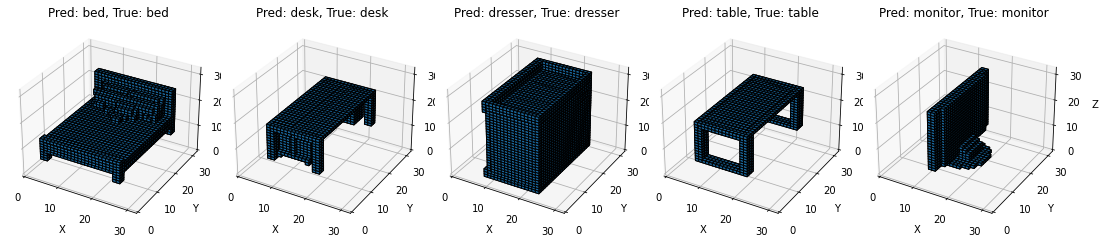

In [4]:
# Choose random samples
num_samples = 5  # Number of random samples to predict
random_indices = random.sample(range(len(test_dataset)), num_samples)

fig = plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    # Get a random sample from the test set
    sample, target = test_dataset[idx]
    sample = sample.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict with the model
    with torch.no_grad():
        output = model(sample.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    # Convert predicted and target labels to numpy if needed
    predicted_label = predicted.item()
    true_label = target.item()  # Assuming target is a scalar label

    sample_np = sample.cpu().squeeze().numpy()
    ax = fig.add_subplot(1, num_samples, i + 1, projection="3d")

    # Voxel plot
    sample_np = (sample_np + 1) / 2
    ax.voxels(sample_np, edgecolor="k")

    ax.set_title(
        f"Pred: {test_dataset.class_map.get(predicted_label)}, True: {test_dataset.class_map.get(true_label)}"
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, sample_np.shape[0])
    ax.set_ylim(0, sample_np.shape[1])
    ax.set_zlim(0, sample_np.shape[2])

plt.tight_layout()
plt.show()

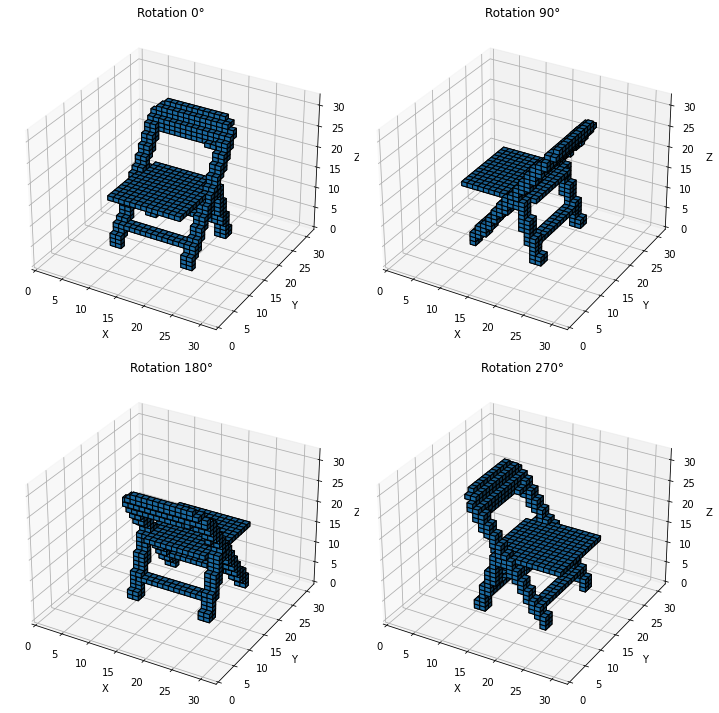

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# List of .pt files to load
dataset = "ModelNet10Voxel_32_28_1_4"
figures = [
    f"{dataset}/chair/train/chair_0001.pt", 
    f"{dataset}/chair/train/chair_0001rot90.pt", 
    f"{dataset}/chair/train/chair_0001rot180.pt",
    f"{dataset}/chair/train/chair_0001rot270.pt",
]

# Set up the figure with 5 rows and 3 columns
num_rows = 2
num_cols = 2
fig = plt.figure(figsize=(10, 10))  # Adjusted height for better visibility

for i, file_path in enumerate(figures):
    # Load the tensor from the .pt file
    sample = torch.load(file_path)
    
    # Move sample to CPU and convert to numpy array
    sample_np = sample.cpu().numpy().squeeze()  # Remove batch dimension if present

    # Create a 3D subplot
    ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')

    sample_np = (sample_np >= 0.5).astype(int)
    # Create voxel plot
    ax.voxels(sample_np, edgecolor='k')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Rotation {i*90}°")

    ax.set_xlim(0, sample_np.shape[0])
    ax.set_ylim(0, sample_np.shape[1])
    ax.set_zlim(0, sample_np.shape[2])

plt.tight_layout()
plt.show()


In [9]:
from torchviz import make_dot

x = torch.randn(batch_size, 1, grid_size, grid_size, grid_size).to(device)  # Example input
y = model(x)  # Forward pass

# Create a visualization of the model
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # Save as PNG


'model_architecture.png'